<a href="https://colab.research.google.com/github/nirala-noir/crowd-counting-using-neural-network-_-4th-sem/blob/main/CROWD_COUNTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RAMAN KUMAR NIRALA 

CROWD COUNTING USIING NEURAL NETWORK

4TH SEM

TEAM: MAVERICK

ASHUTOSH PRATAP SINGH 

JITENDRA DHAKAD

DATASET- SANGHAI ITEC @ KAGGLE


import library


In [ ]:
import numpy as np
import pandas as pd
import os
print(os.listdir("/content/drive/MyDrive/shanghaitech_with_people_density_map"))

['ShanghaiTech']


In [ ]:
import glob
print(os.listdir("/content/drive/MyDrive/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data"))

['ground-truth', 'images', 'ground-truth-h5']


providing path of train-data and test-data

In [ ]:
DATA_PATH = "/content/drive/My Drive/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data"
TEST_PATH = "/content/drive/My Drive/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data"
MODEL_PATH = "csrnet_shanghaitechA_task1.model"
MODEL_JSON_PATH = "csrnet_shanghaitechA_task1.json"

In [ ]:
import os
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import json

#function for creating the training of all images in list

def create_training_image_list(data_path):
    #storing path of jpeg file
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    return image_path_list

#function for getting the trained list of all images
def get_train_val_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val

def get_test_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    
    print("test size ", len(image_path_list))
    return image_path_list

#function for creating path for density images in list
def create_density_path_list(image_path_list):
    gt_paths = []
    for img_path in image_path_list:
        gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth-h5')
        gt_paths.append(gt_path)
    return gt_paths


In [ ]:
from tensorflow.keras import backend as K
def mae_metric(y_true, y_pred):
    return K.abs(K.sum(y_true) - K.sum(y_pred))

In [ ]:
# Euclidean distance as a measure of loss (Loss function)
from tensorflow.keras import backend as K
def euclidean_distance_loss(y_true, y_pred):
      return K.sqrt(K.sum(K.sum(K.sum(K.square(y_pred - y_true), axis=3), axis=2), axis=1))

In [ ]:
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.initializers import RandomNormal 
import numpy as np
from tensorflow.keras.optimizers import SGD, Adam

#function for building our model for convert images in 2D format 
def build_model():
    sgd = SGD(lr=1e-7, decay=5*1e-4, momentum=0.95)
    adam = Adam()
    vgg16_model = VGG16(weights='imagenet', include_top=False)
   
    x = vgg16_model.get_layer('block4_conv3').output
    x = BatchNormalization()(x)
#     x = UpSampling2D(size=(8, 8))(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(1, 1), dilation_rate=1, padding='same', use_bias=True, kernel_initializer=RandomNormal(stddev=0.01))(x)
#     x = BatchNormalization()(x)
    x = Activation('relu')(x)
    model = Model(inputs=vgg16_model.input, outputs=x)
    model.compile(optimizer=adam,
                  loss=mean_squared_error, metrics=[mae_metric])
    return model


In [ ]:
#now save model and json file of dataset
def save_model(model , weight_path , json_path):
    
    model.save_weights(weight_path)
    
    model_json = model.to_json()
    
    with open(json_path, "w") as json_file:
        json_file.write(model_json)

In [ ]:
# now load model and json file
def load_json_model(weight_path, json_path):
    """
    load model and json file
    source = https://github.com/Neerajj9/CSRNet-keras/blob/master/Model.ipynb
    """
    # Function to load and return neural network model 
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weight_path)
    return loaded_model

In [ ]:
#getting all files stored from model i.e; download our data
model = build_model()

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
#This is a convenience function. If we want an interface that takes a shape-tuple as the first argument
x = np.random.rand(1, 224, 224, 3)
pred = model.predict(x)
print(pred.shape)

(1, 28, 28, 1)


In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

now working with created density files

In [ ]:
from tensorflow.keras.utils import Sequence

import numpy as np
import h5py
import PIL.Image as Image

#load all density files

def load_density(file_path):
    gt_file = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt_file['density'])
    return groundtruth

def downsample_density_map(density):
    density2 = density.squeeze(3).squeeze(0)
    density3 = cv2.resize(density2,(int(density2.shape[1]/8), int(density2.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    density4 = np.expand_dims(density3, axis=0)
    density5 = np.expand_dims(density4, axis=3)
    return density5
    
#crop or fitting all image size in certain size
def random_crop(img, density_map, random_crop_size):
    
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :], density_map[y:(y+dy), x:(x+dx), :]


class DatasetSequence(Sequence):

    def __init__(self, image_path_list, density_path_list, random_crop_size=None, same_size_density=True):
        self.image_path_list = image_path_list
        self.density_path_list = density_path_list
        self.random_crop_size = random_crop_size
        self.batch_size = 1
        self.same_size_density = same_size_density
        
    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, idx):
        try:
            image_path = self.image_path_list[idx]
            density_path = self.density_path_list[idx]

            density = load_density(density_path)
            image = np.array(Image.open(image_path, "r").convert("RGB"))
            density = np.expand_dims(density, axis=2)  # add channel dim

            if self.random_crop_size is not None:
                # print("crop ", self.random_crop_size)
                image, density = random_crop(image, density, self.random_crop_size)        
    
            # preprocess vgg16 input
            im = image
            im = im/255.0
            im[:,:,0]=(im[:,:,0]-0.485)/0.229
            im[:,:,1]=(im[:,:,1]-0.456)/0.224
            im[:,:,2]=(im[:,:,2]-0.406)/0.225
            image = im

            # density = np.expand_dims(density, axis=3)  # add channel dim
            image = np.expand_dims(image, axis=0) # add batch dim
            density = np.expand_dims(density, axis=0) # add batch dim
            
            if not self.same_size_density:
                density = downsample_density_map(density)

            return image, density
        except:
            pass
        
    def get_non_preprocess(self, idx):
        try:
            image_path = self.image_path_list[idx]
            density_path = self.density_path_list[idx]

            density = load_density(density_path)
            image = np.array(Image.open(image_path, "r").convert("RGB"))
            density = np.expand_dims(density, axis=3)  # add channel dim
                
            # density = np.expand_dims(density, axis=3)  # add channel dim
            image = np.expand_dims(image, axis=0) # add batch dim
            density = np.expand_dims(density, axis=0) # add batch dim

            return image, density
        except:
            pass

    def get_random_crop_image(self, idx):
#         try:
        image_path = self.image_path_list[idx]
        density_path = self.density_path_list[idx]

        density = load_density(density_path)
        image = np.array(Image.open(image_path, "r").convert("RGB"))
        density = np.expand_dims(density, axis=3)  

        if self.random_crop_size is not None:
           
            image, density = random_crop(image, density, self.random_crop_size)
            
       
        im = image
        im = im/255.0
        im[:,:,0]=(im[:,:,0]-0.485)/0.229
        im[:,:,1]=(im[:,:,1]-0.456)/0.224
        im[:,:,2]=(im[:,:,2]-0.406)/0.225
        image = im

        image = np.expand_dims(image, axis=0) 
        density = np.expand_dims(density, axis=0)  
        return image, density

    def get_random_crop_image_batch(self, idx, batch_size):
        image_batch = []
        density_batch = []
        
        for i in range(batch_size):
            image, density = self.get_random_crop_image(idx)
            image_batch.append(image)
            density_batch.append(density)

        images = np.concatenate(image_batch, axis=0)
        densities = np.concatenate(density_batch, axis=0)
        return images, densities
    
    def get_all(self, crop_per_img):
        image_list = []
        density_list = []
        for i in tqdm(range(len(self.image_path_list))):
            try:
                image, density = self.get_random_crop_image_batch(i, crop_per_img)
                image_list.append(image)
                density_list.append(density)
            except:
                print("exception at image ", i)
        image_mat = np.concatenate(image_list, axis = 0)
        density_mat = np.concatenate(density_list, axis = 0)
        return image_mat, density_mat

getting size of train size and val size

In [ ]:
train_img_path, val_img_path = get_train_val_list(DATA_PATH)
train_density_path = create_density_path_list(train_img_path)
val_density_path = create_density_path_list(val_img_path)

train size  270
val size  30


In [ ]:
train_dataset = DatasetSequence(train_img_path, train_density_path, random_crop_size=(224, 224), same_size_density=False)

In [ ]:
img,density = train_dataset[0]

In [ ]:
density.shape

(1, 28, 28, 1)

In [ ]:
density2 = density.squeeze(3).squeeze(0)
density3 = cv2.resize(density2,(int(density2.shape[1]/8), int(density2.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
density4 = np.expand_dims(density3, axis=0)
density5 = np.expand_dims(density4, axis=3)
print(density3.shape)
print(density2.shape)
print(density5.shape)

(3, 3)
(28, 28)
(1, 3, 3, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

now epoch all data or give training to code because gradient decent has to run for all hidden layers bcz it is iterative method
One epoch means that the optimizer has used every training example once. 

In [ ]:
model = build_model()

# for image, density in dataset:
#     model.fit(image, density)
epoch = 10
print("total epoch ", epoch)
model.fit(train_dataset, shuffle=True, epochs = epoch)
save_model(model, MODEL_PATH, MODEL_JSON_PATH)
import sys
sys.stdout.flush()

now evaluate our output section

In [ ]:
loaded_model = load_json_model(MODEL_PATH, MODEL_JSON_PATH)

In [ ]:

import glob
import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import os
import numpy as np


def save_density_map(density_map, name):
    plt.figure(dpi=600)
    plt.axis('off')
    plt.margins(0, 0)
    plt.imshow(density_map, cmap=CM.jet)
    plt.savefig(name, dpi=600, bbox_inches='tight', pad_inches=0)


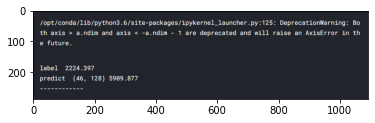

In [ ]:
plt.imshow(mpimg.imread('/content/1.png'))

In [ ]:
# train_dataset
img_train, density_train = train_dataset.get_non_preprocess(0)
pil_img = Image.fromarray(img_train[0])

model = load_json_model(MODEL_PATH, MODEL_JSON_PATH)

print("label ", density_train.sum())

# img_train = preprocess_input(img_train)
pred = model.predict(img_train)
# pred = loaded_model.predict(img_train)

print("predict ", np.squeeze(pred[0], axis=2).shape, np.squeeze(pred[0], axis=2).sum())

print("------------")

show the image

In [ ]:
pil_img.save("train.png")
from matplotlib import pyplot as plt


plt.figure(dpi=600)
plt.axis('off')
plt.margins(0,0)
plt.imshow(Image.open("train.png"))

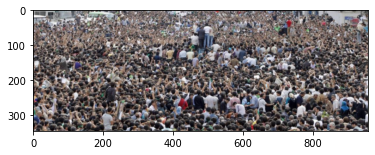

In [ ]:
plt.imshow(mpimg.imread('/content/2.png'))

show the density map

In [ ]:
save_density_map(np.squeeze(density_train[0], axis=2), "label.png")

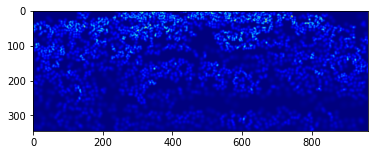

In [ ]:
plt.imshow(mpimg.imread('/content/3.png'))

show the array data of an image

In [ ]:
np.squeeze(pred[0], axis=2).shape

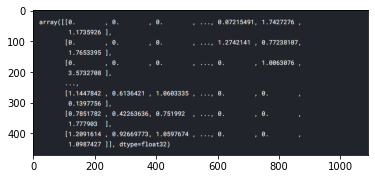

In [ ]:
plt.imshow(mpimg.imread('/content/4.png'))

show the image of prediction based on the above array

In [ ]:
save_density_map(np.squeeze(pred[0], axis=2), "predict.png")

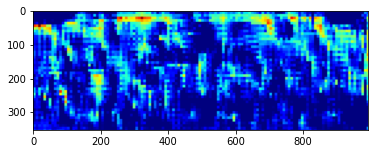

In [ ]:
plt.imshow(mpimg.imread('/content/5.png'))

show the prediction shape

In [ ]:
pred[0].shape

In [ ]:
np.savetxt("pred_np.txt",np.squeeze(density_train[0], axis=2))

VALIDATE OUR DATA AND MODEL VALUE

In [ ]:
val_dataset = DatasetSequence(val_img_path, val_density_path, same_size_density=False)

In [ ]:
n = 0
mae = 0
mse = 0
for i in tqdm(range(len(val_dataset))):
    img, density = val_dataset[i]
    # img = preprocess_input(img)
    pred = model.predict(img)
    pred_values = pred.sum()
    truth = density.sum()
    mae = mae + abs(truth - pred_values)
    n += 1
    mse = mse + (truth - pred_values) * (truth - pred_values)

val_result_mae = mae / n
val_result_mse = np.sqrt(mse/n)
print('val mae ', val_result_mae)
print('val mse ', val_result_mse)

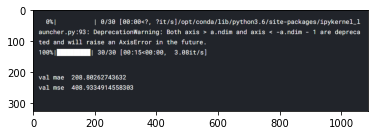

In [ ]:
plt.imshow(mpimg.imread('/content/7.png'))

TEST DATA


In [ ]:
test_img_path = get_test_list(TEST_PATH)
test_density_path = create_density_path_list(test_img_path)

In [ ]:
test_dataset = DatasetSequence(test_img_path, test_density_path, same_size_density=False)
# model = load_model(MODEL_PATH)

In [ ]:
n = 0
mae = 0
mse = 0
for i in tqdm(range(len(test_dataset))):
    img, density = test_dataset[i]
    # img = preprocess_input(img)
    pred = model.predict(img)
    pred_values = pred.sum()
    truth = density.sum()
    mae = mae + abs(truth - pred_values)
    n += 1
    mse += (truth - pred_values) * (truth - pred_values)
mae = mae / n
mse = np.sqrt(mse / n)
print(mae)
print(mse)

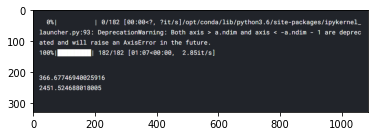

In [ ]:
plt.imshow(mpimg.imread('/content/8.png'))